In [1]:
from collections import defaultdict
from gurobipy import *
from pandas import read_excel
filename = "buad5092-m7-final-integration-US-mileage.xlsx"

## Q1

\begin{align*}
\min_x \quad \sum_{i=1}^n (demand * service^T)_i \\
s.t. \sum_{i=1}^{12} is\_service\_center_i = 3 \\
service_{i*} = 1 \; \forall i \in [1,997] \\
service_{*j} \leq 997 \; \forall j \in [1,12] \\
is\_service\_center_j = Or(service_{*j}) \; \forall j \in [1,12] \\
\end{align*}

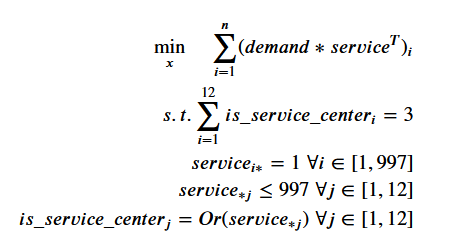

## Q2

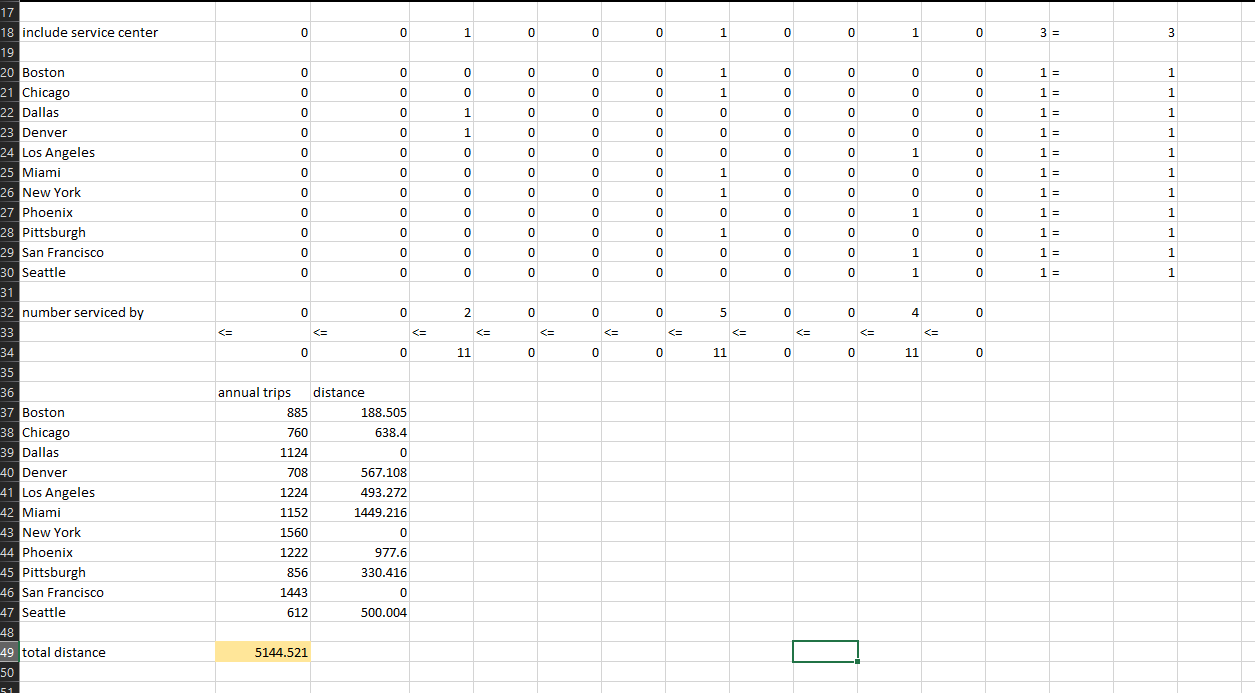

## function

In [2]:
def opt(sheet, data_type):

  # data
  m = Model()
  data = read_excel(filename, sheet_name=f"{sheet}-{data_type}")
  data_demand = read_excel(filename, sheet_name=f"{sheet}-demand")
  num_rows, num_cols = data.shape[0], data.shape[1] - 1
  locs_rows, locs_cols = [data.iloc[i][0] for i in range(num_rows)], list(data.columns.values)[1:]
  demands = {locs_cols[i].replace(" ", "-"): int(data_demand.get(locs_cols[i])) for i in range(num_cols)}
  # remove spaces in city names for Gurobi format files
  locs_rows, locs_cols = [i.replace(" ", "-") for i in locs_rows], [i.replace(" ", "-") for i in locs_cols]

  # variables
  service_centers, is_serviced_by = defaultdict(list), defaultdict(list)
  is_service_center_vars = {locs_cols[i]: m.addVar(vtype=GRB.BINARY, name=f"is_service_center_{locs_cols[i]}") for i in range(num_cols)}
  for i in range(num_cols):
    for j in range(num_rows):
      v = m.addVar(vtype=GRB.BINARY, name=f"{locs_cols[i]}_is_service_center_for_{locs_rows[j]}")
      service_centers[locs_rows[j]].append(v)
      is_serviced_by[locs_cols[i]].append(v)
  v = None
  m.update()

  # constraints
  m.addLConstr(quicksum(is_service_center_vars.values()), GRB.EQUAL, 3)
  for i in range(num_cols):
    m.addLConstr(quicksum(is_serviced_by[locs_cols[i]]), GRB.LESS_EQUAL, num_rows)
    m.addGenConstrOr(is_service_center_vars[locs_cols[i]], is_serviced_by[locs_cols[i]])
    for j in range(num_rows):  m.addLConstr(quicksum(service_centers[locs_rows[j]]), GRB.EQUAL, 1)
  m.update()

  # objective
  distances = [quicksum([x * y for (x,y) in zip(service_centers[locs_rows[i]], data.loc[i][1:])]) for i in range(num_rows)]
  obj = [(demands[locs_cols[i]] * distances[i] / 1000) for i in range(num_cols)]
  m.setObjective(quicksum(obj), GRB.MINIMIZE)
  m.update()
  m.optimize()
  # m.display()
  print(m.objVal)

  # format output
  s, t = defaultdict(list), defaultdict(list)
  for i in m.getVars():
    if i.x > 0:
      if "is_service_center_for_" in i.varName:
        s[i.varName[:i.varName.index("_")]].append(i.varName[i.varName.rindex("_")+1:])
  for i, j in s.items():  t[i.replace("-", " ")] = [k.replace("-", " ") for k in j]
  tt = [{k: v} for (k, v) in t.items()]

  print("\n\nOUTPUT: \n\n")
  print(f"The minimized total distance is {round(m.objVal, 3)} {data_type}.\n\n")
  print(f"The 3 manufacturing sites are located at {list(t.keys())[0]} and {list(t.keys())[1]} and {list(t.keys())[2]}.\n\n")
  print(f"The manufacturing site assignments are: \n\n  {tt[0]} \n\n  {tt[1]} \n\n  {tt[2]}\n\n")
  print("done.\n\n")
  return (round(m.objVal, 3))


## Q3

In [3]:
opt("ex65", "miles")

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-05-04
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 133 rows, 132 columns and 1463 nonzeros
Model fingerprint: 0xfb39f69c
Model has 11 general constraints
Variable types: 0 continuous, 132 integer (132 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve added 11 rows and 0 columns
Presolve time: 0.00s
Presolved: 144 rows, 132 columns, 506 nonzeros
Variable types: 0 continuous, 132 integer (132 binary)
Found heuristic solution: objective 9626.9570000

Root relaxation: objective 5.144521e+03, 50 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objectiv

5144.521

## Q4

In [4]:
opt("st", "miles")

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11977 rows, 11976 columns and 155544 nonzeros
Model fingerprint: 0x9929f8f5
Model has 12 general constraints
Variable types: 0 continuous, 11976 integer (11976 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve added 997 rows and 0 columns
Presolve time: 0.09s
Presolved: 12974 rows, 11976 columns, 47880 nonzeros
Variable types: 0 continuous, 11976 integer (11976 binary)
Found heuristic solution: objective 15778.440770

Root relaxation: objective 7.573597e+03, 4942 iterations, 0.05 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7573.5970461 7573.59705  

7573.597

## Q5

In [5]:
opt("st", "hours")

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11977 rows, 11976 columns and 155544 nonzeros
Model fingerprint: 0x7ebc9362
Model has 12 general constraints
Variable types: 0 continuous, 11976 integer (11976 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve added 997 rows and 0 columns
Presolve time: 0.09s
Presolved: 12974 rows, 11976 columns, 47880 nonzeros
Variable types: 0 continuous, 11976 integer (11976 binary)
Found heuristic solution: objective 179.9224250

Root relaxation: objective 1.123558e+02, 4929 iterations, 0.08 seconds (0.15 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     112.3558094  112.35581  0

112.356

## Q6

The 3 manufacturing sites should be located at Miami, FL and Phoenix, AZ and Pittsburgh, PA. This selection of manufacturing sites minimizes the total distance and total time required for travel. This site assignment partitions the assigned cities for each of the 3 sites based on demand and distance.

## Q7

A naive heuristic I might use is splitting the area into 3 equal parts and picking the most central city of each zone as a site, assigning every other city in the same zone to that site. This can be done vertically, horizontally, or using another shape. 
\
Another heuristic that could be used is the all-pairs shortest path problem (solved using the Floyd-Warshall algorithm). By finding all shortest paths between each pair of cities and summing them for each city, the cities with the minimum sums of shortest paths to all other cities can be selected as sites.